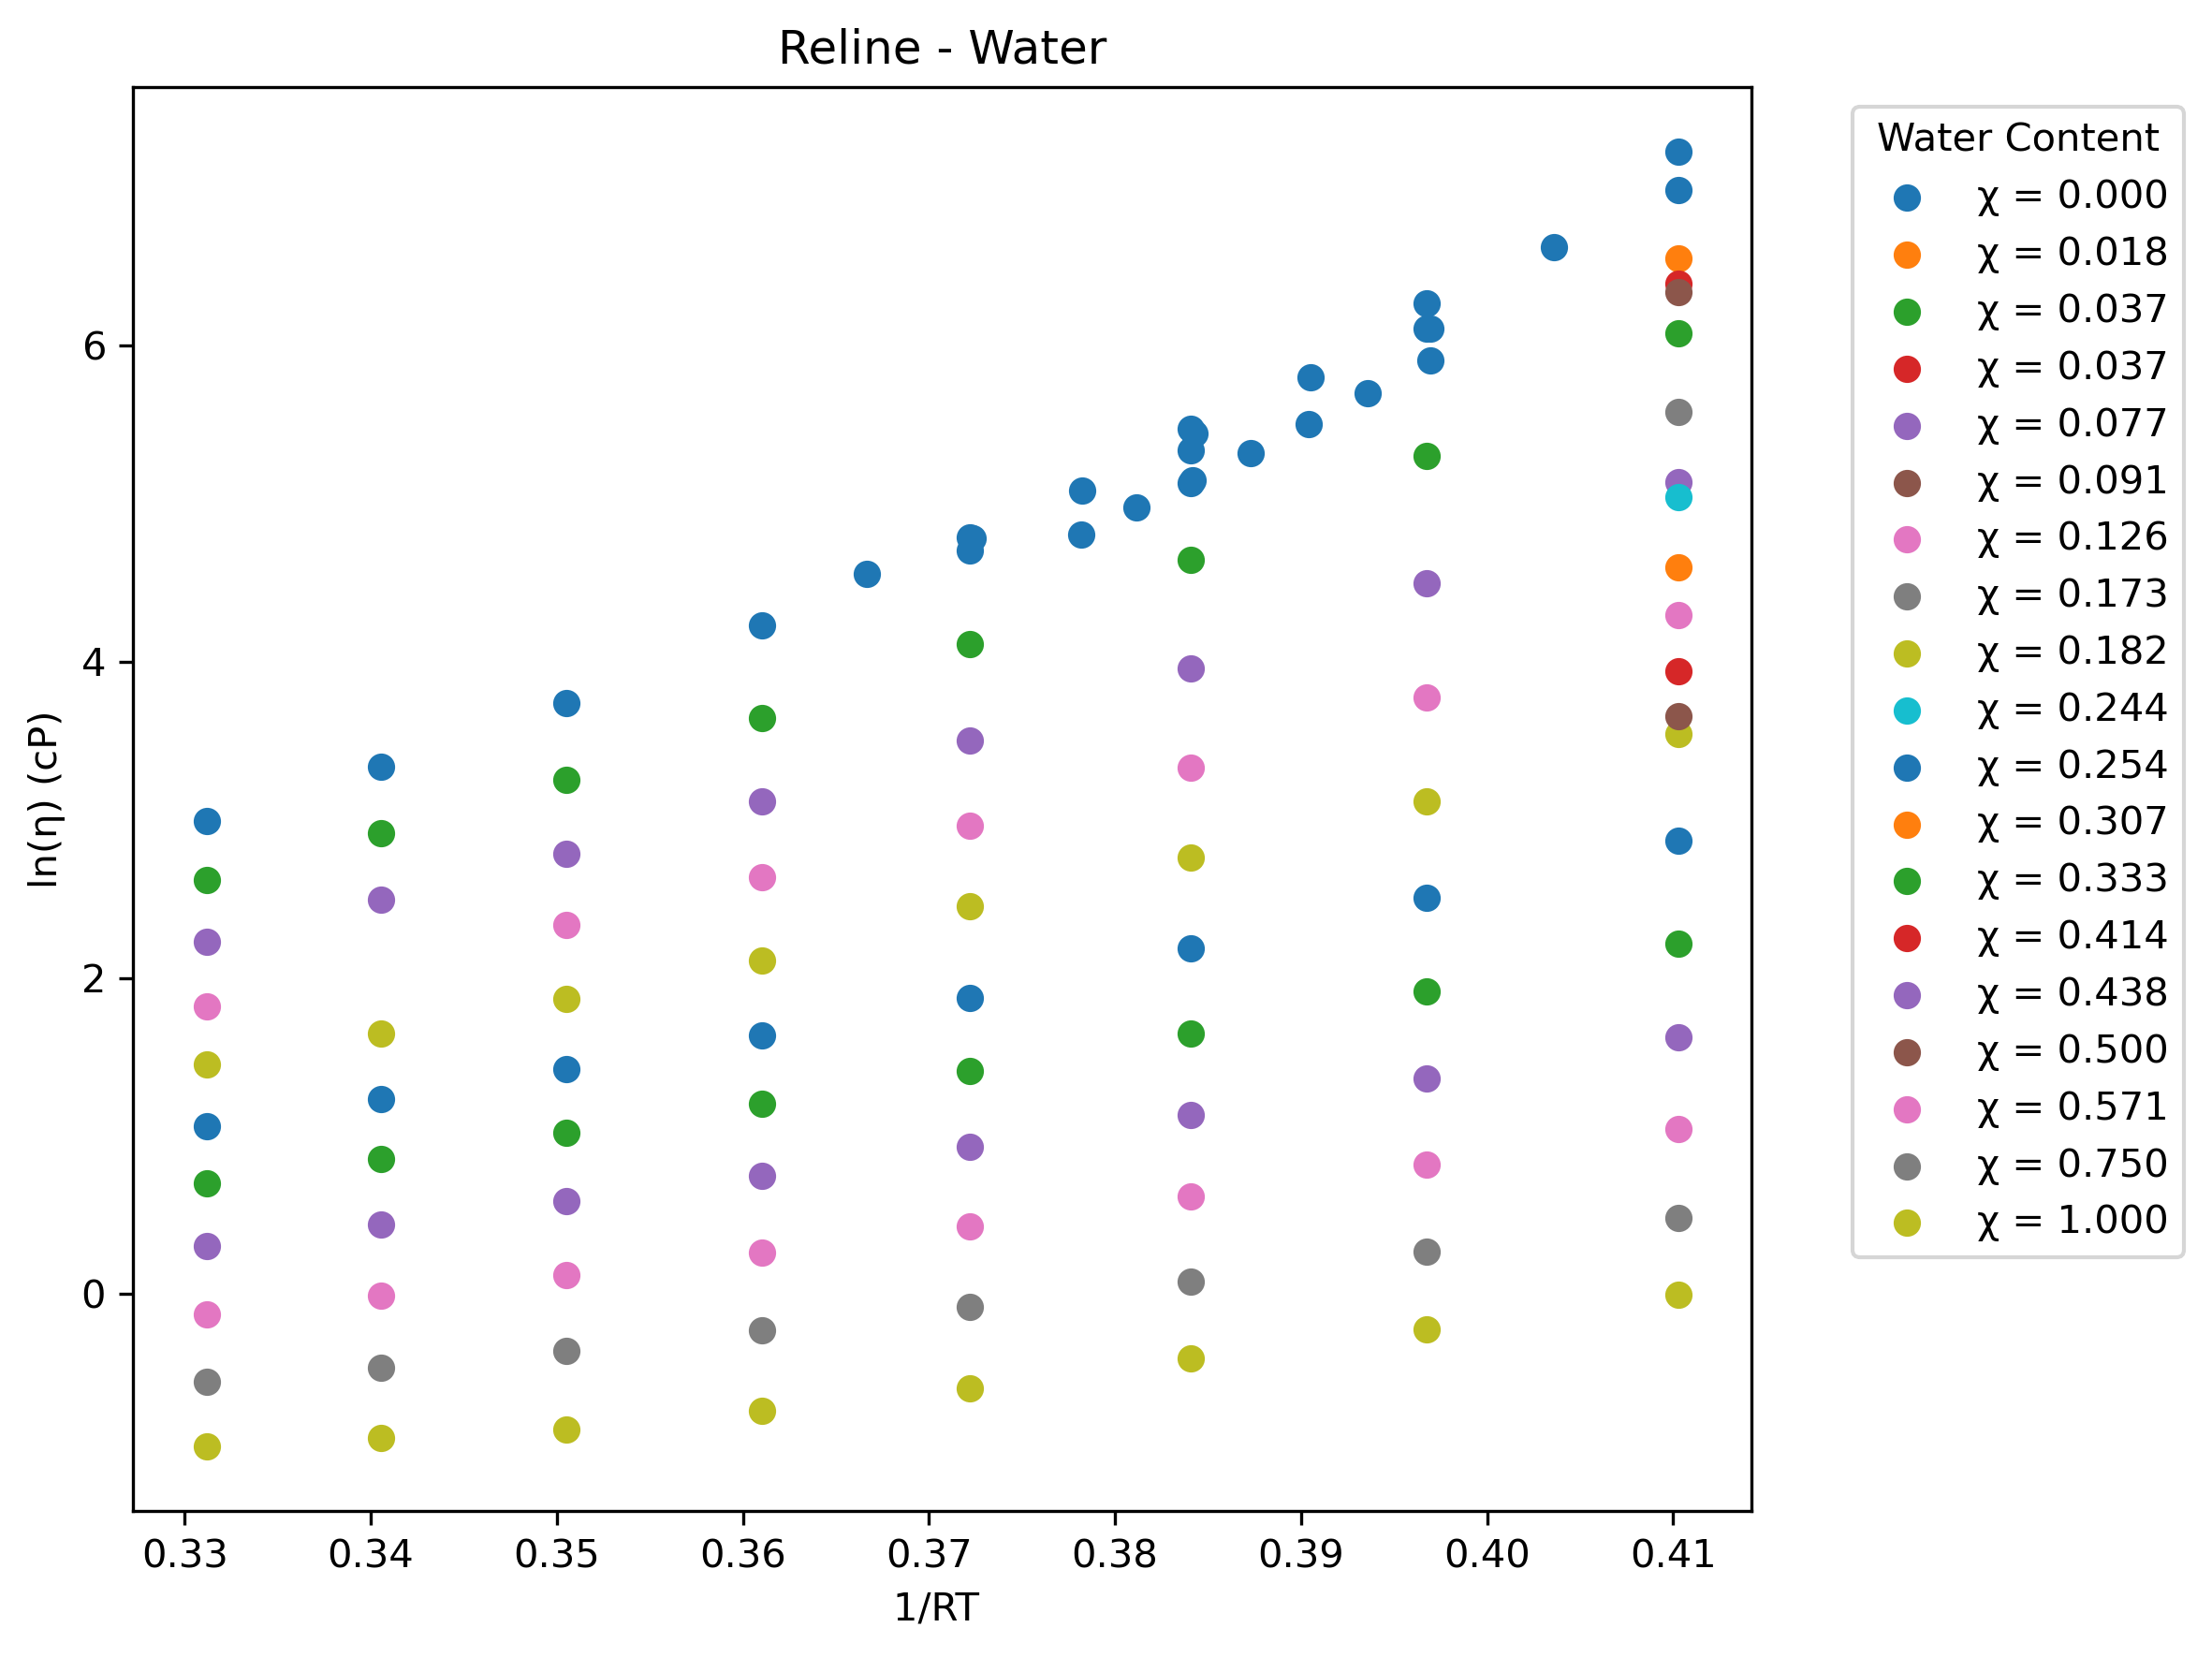

In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_dir = "/home/sga/Code/FAIRFluids/FAIRFluids/data/csvs"
file_path = os.path.join(csv_dir, "exp_ChCl_urea.csv")
R = 8.31446261815324

try:
    df = pd.read_csv(file_path)
    temps = 10000/(df['temperature (K)']*R)
    
    # First plot - ln(Viscosity) vs 1/RT
    plt.figure(figsize=(8,6), dpi=300)
    for mole_frac, group in df.groupby('mole fraction of water (mol/mol)'):
        group_temps = 1000/(group['temperature (K)']*R)
        plt.scatter(group_temps, np.log(group['Viscosity(cP)']), label=f'χ = {mole_frac:.3f}')
        
    plt.xlabel('1/RT ')
    plt.ylabel('ln(η) (cP)')
    plt.title('Reline - Water')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Water Content')
    plt.tight_layout()
    plt.savefig('1.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"Error reading exp_ChCl_urea.csv: {str(e)}")

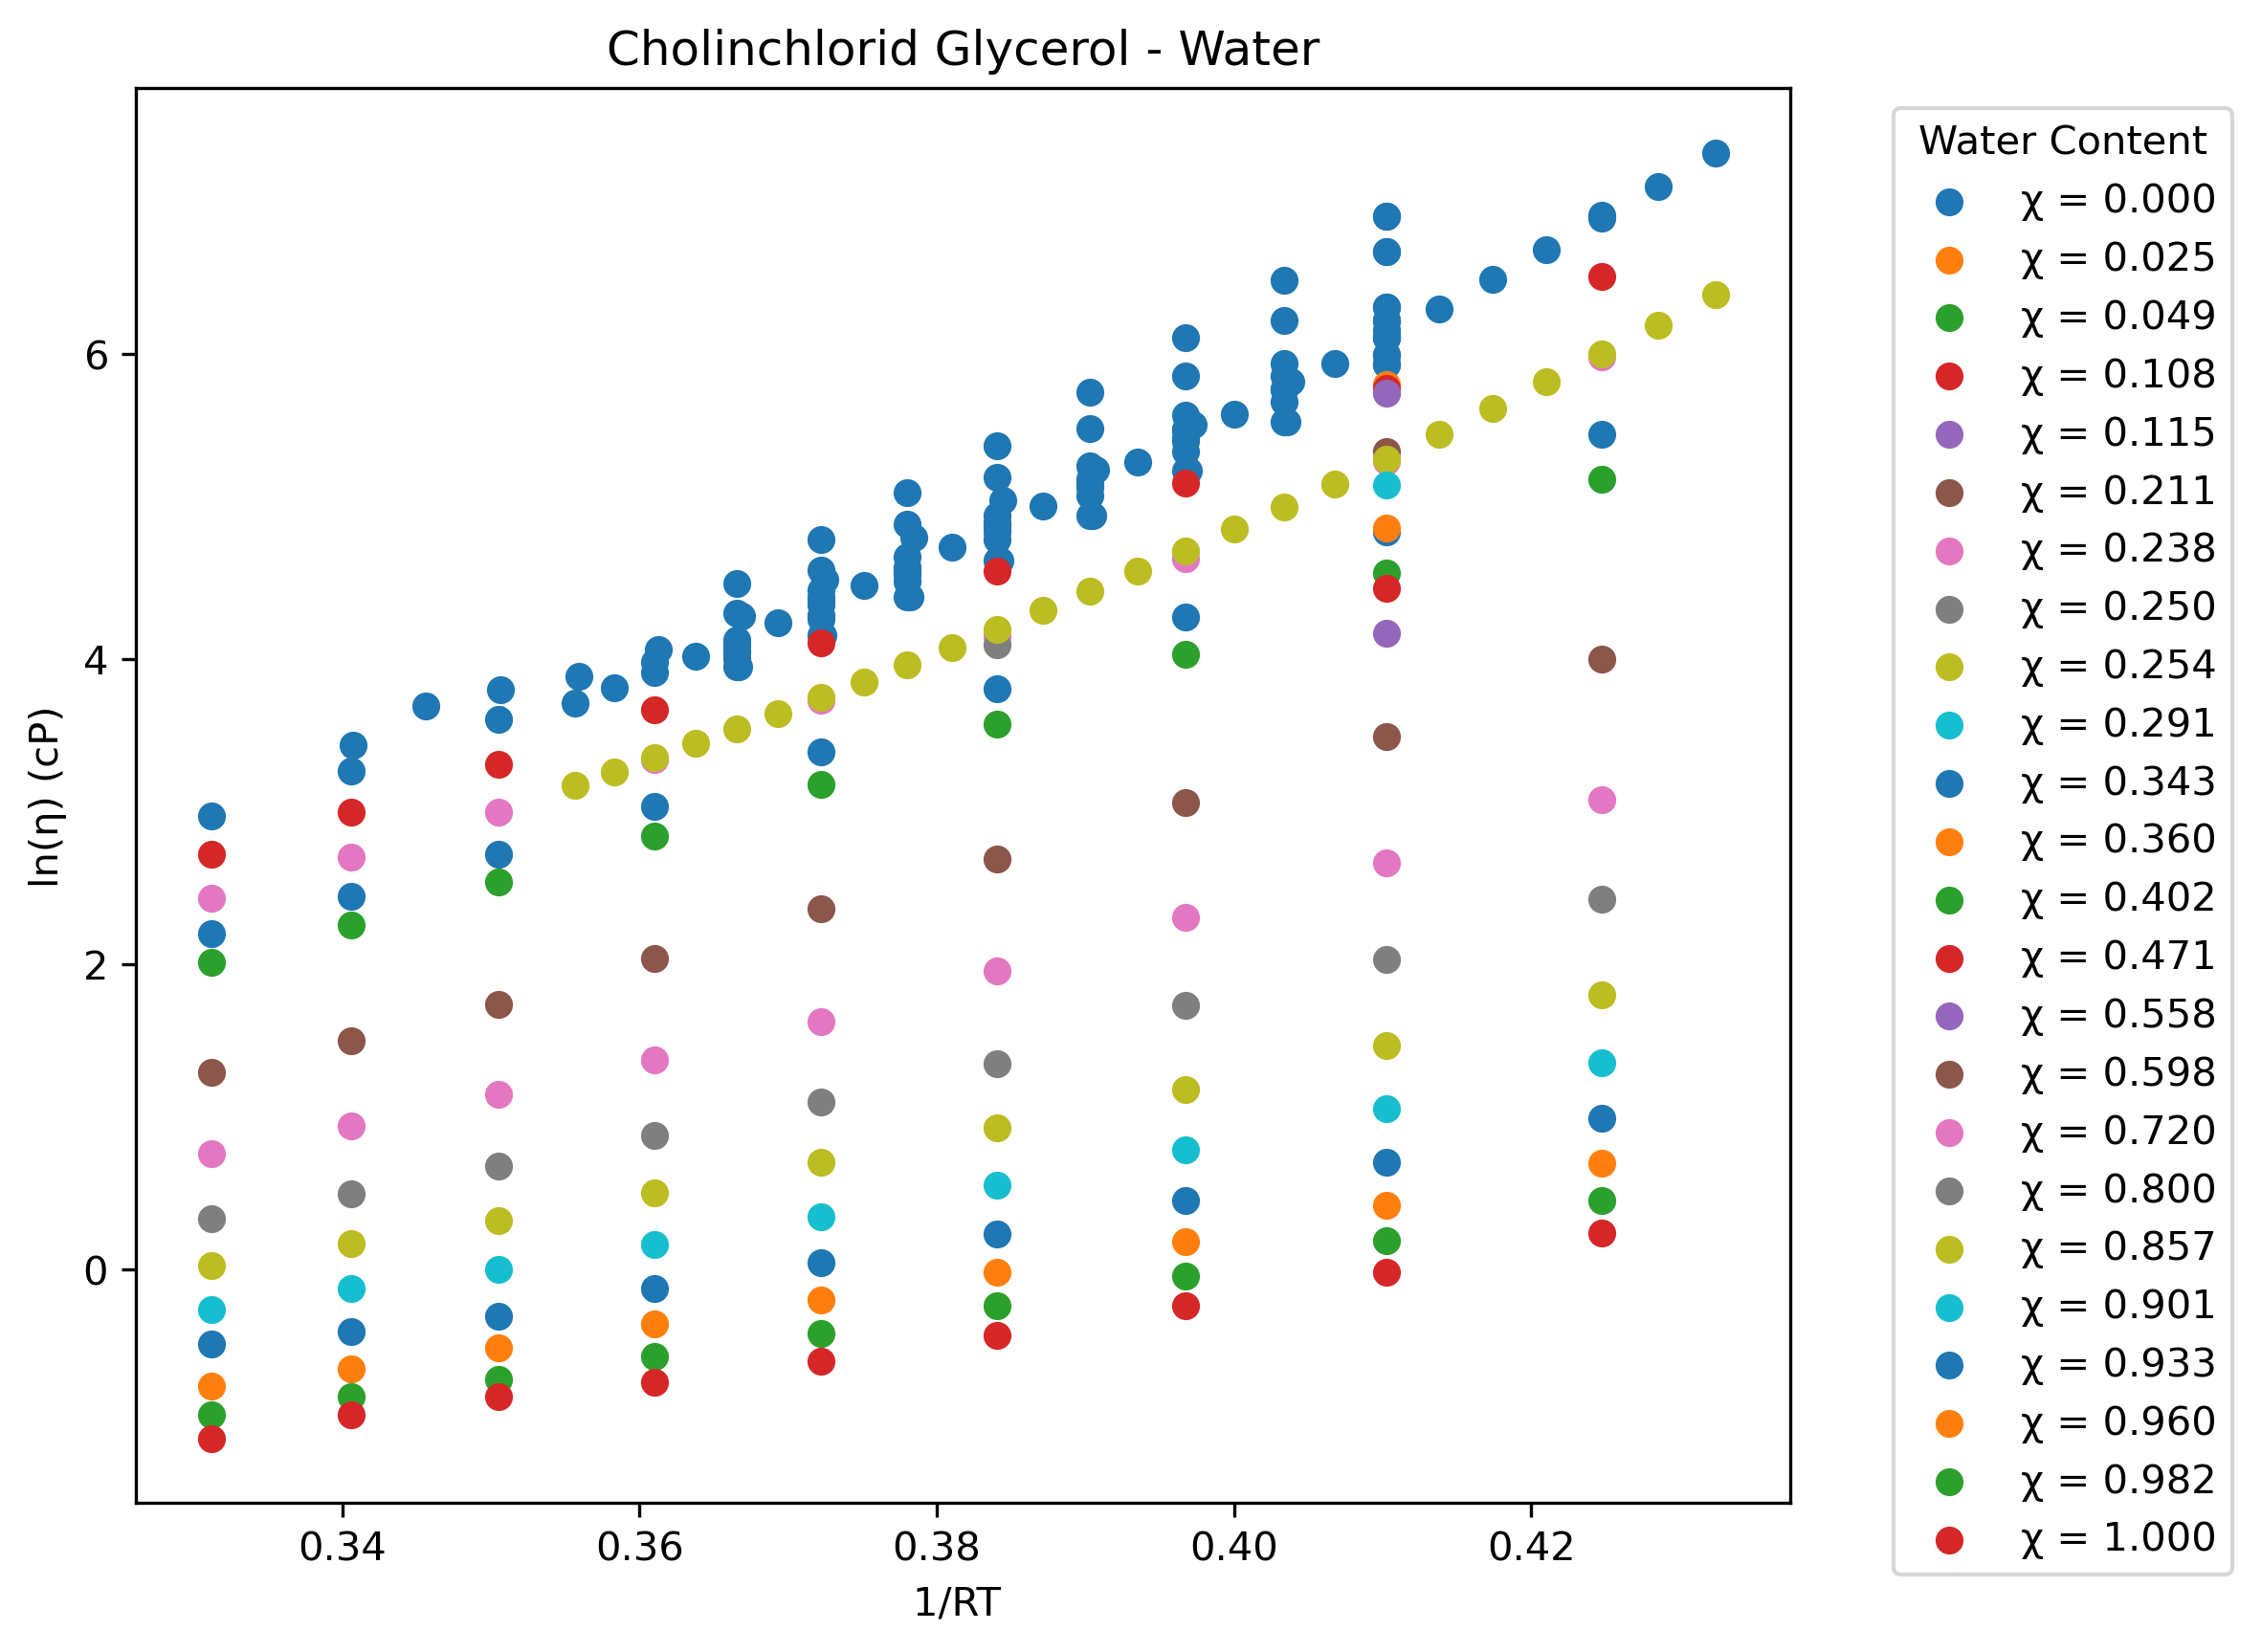

In [56]:
csv_dir = "/home/sga/Code/FAIRFluids/FAIRFluids/data/csvs"
file_path = os.path.join(csv_dir, "/home/sga/Code/FAIRFluids/FAIRFluids/data/csvs/exp_ChCl_glycerol.csv")
R = 8.31446261815324

try:
    df2 = pd.read_csv(file_path)
    temps = 10000/(df2['temperature (K)']*R)
    
    # First plot - ln(Viscosity) vs 1/RT
    plt.figure(figsize=(8,6), dpi=300)
    for mole_frac, group in df2.groupby('mole fraction of water (mol/mol)'):
        group_temps = 1000/(group['temperature (K)']*R)
        plt.scatter(group_temps, np.log(group['Viscosity(cP)']), label=f'χ = {mole_frac:.3f}')
        
    plt.xlabel('1/RT ')
    plt.ylabel('ln(η) (cP)')
    plt.title('Cholinchlorid Glycerol - Water')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  title='Water Content')
    plt.tight_layout()
    plt.savefig('2.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"Error reading exp_ChCl_urea.csv: {str(e)}")

/tmp/ipykernel_3509/1084849905.py:7: RuntimeWarning: divide by zero encountered in log
  plt.scatter(water_fractions, -np.log(slope_values)*10)


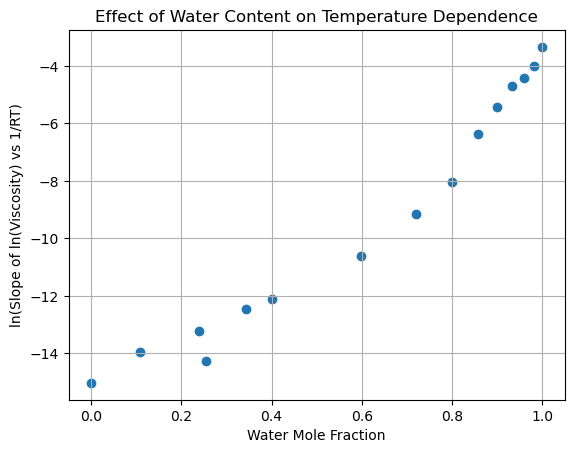

In [57]:
# Extract water fractions and slopes into lists for plotting
water_fractions = [float(key.split('=')[1]) for key in slopes.keys()]
slope_values = list(slopes.values())

# Create the plot
plt.figure()
plt.scatter(water_fractions, -np.log(slope_values)*10)
plt.xlabel('Water Mole Fraction')
plt.ylabel('ln(Slope of ln(Viscosity) vs 1/RT)')
plt.title('Effect of Water Content on Temperature Dependence')
plt.grid(True)
plt.show()



Activation Energies (kJ/mol) for each water fraction:
x_water = 0.000: 51.15
x_water = 0.037: 43.36
x_water = 0.077: 36.35
x_water = 0.126: 31.09
x_water = 0.182: 26.49
x_water = 0.254: 22.82
x_water = 0.333: 19.09
x_water = 0.438: 16.60
x_water = 0.571: 14.84
x_water = 0.750: 13.17
x_water = 1.000: 12.40


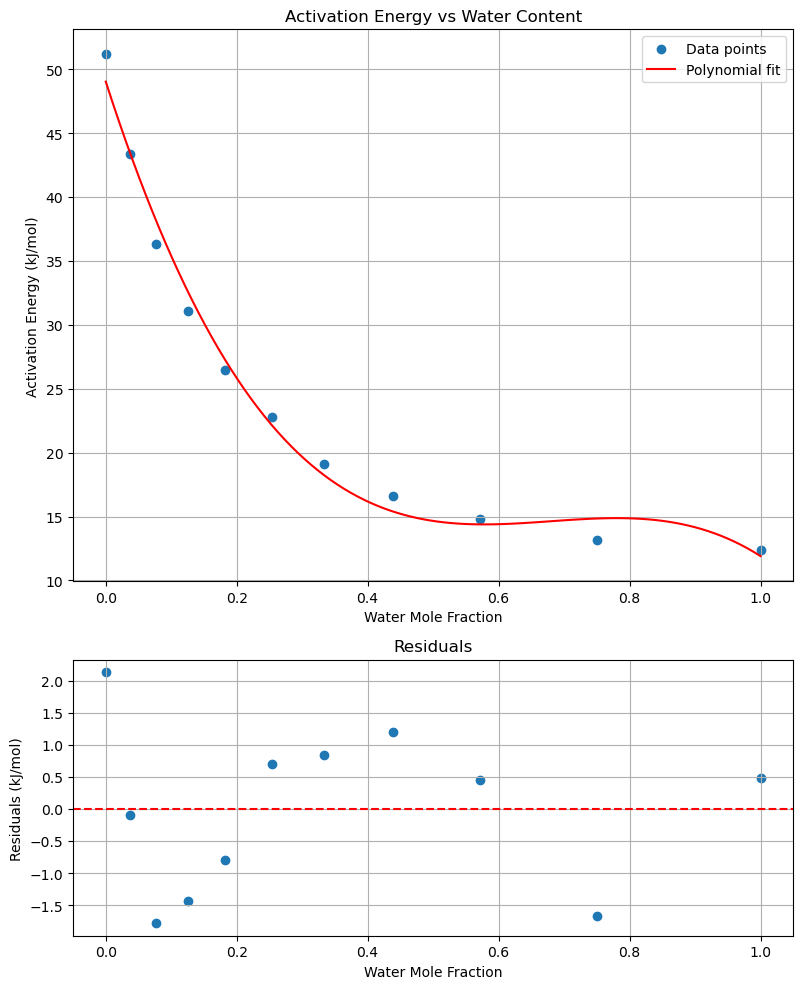

In [63]:
# Calculate activation energy (E) for each water fraction
activation_energies = {}
R = 8.314  # Gas constant in J/(mol·K)

for mole_frac, group in df.groupby('mole fraction of water (mol/mol)'):
    # Only analyze groups with at least 3 temperature points
    if len(group) >= 3:
        temps = 1/(group['temperature (K)'])
        log_visc = np.log(group['Viscosity(cP)'])
        
        # Reshape for sklearn
        X = temps.values.reshape(-1, 1)
        y = log_visc.values.reshape(-1, 1)
        
        # Fit linear regression
        reg = LinearRegression().fit(X, y)
        
        # Calculate activation energy (slope * R)
        E = reg.coef_[0][0] * R
        activation_energies[f'x_water = {mole_frac:.3f}'] = E/1000  # Convert to kJ/mol

print("\nActivation Energies (kJ/mol) for each water fraction:")
for water_frac, E in activation_energies.items():
    print(f"{water_frac}: {E:.2f}")

# Plot activation energies vs water fraction
water_fractions = [float(key.split('=')[1]) for key in activation_energies.keys()]
E_values = list(activation_energies.values())

# Fit polynomial regression
z = np.polyfit(water_fractions, E_values, 3)  # 3rd degree polynomial
p = np.poly1d(z)

# Generate points for smooth curve
x_smooth = np.linspace(min(water_fractions), max(water_fractions), 100)
y_smooth = p(x_smooth)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), height_ratios=[2, 1])

# Top plot - Activation Energy vs Water Content
ax1.scatter(water_fractions, E_values, label='Data points')
ax1.plot(x_smooth, y_smooth, 'r-', label='Polynomial fit')
ax1.set_xlabel('Water Mole Fraction')
ax1.set_ylabel('Activation Energy (kJ/mol)')
ax1.set_title('Activation Energy vs Water Content')
ax1.grid(True)
ax1.legend()

# Bottom plot - Residuals
y_pred = p(water_fractions)
residuals = E_values - y_pred
ax2.scatter(water_fractions, residuals)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Water Mole Fraction')
ax2.set_ylabel('Residuals (kJ/mol)')
ax2.set_title('Residuals')
plt.savefig('6.png', dpi=300)
ax2.grid(True)

plt.tight_layout()
plt.show()


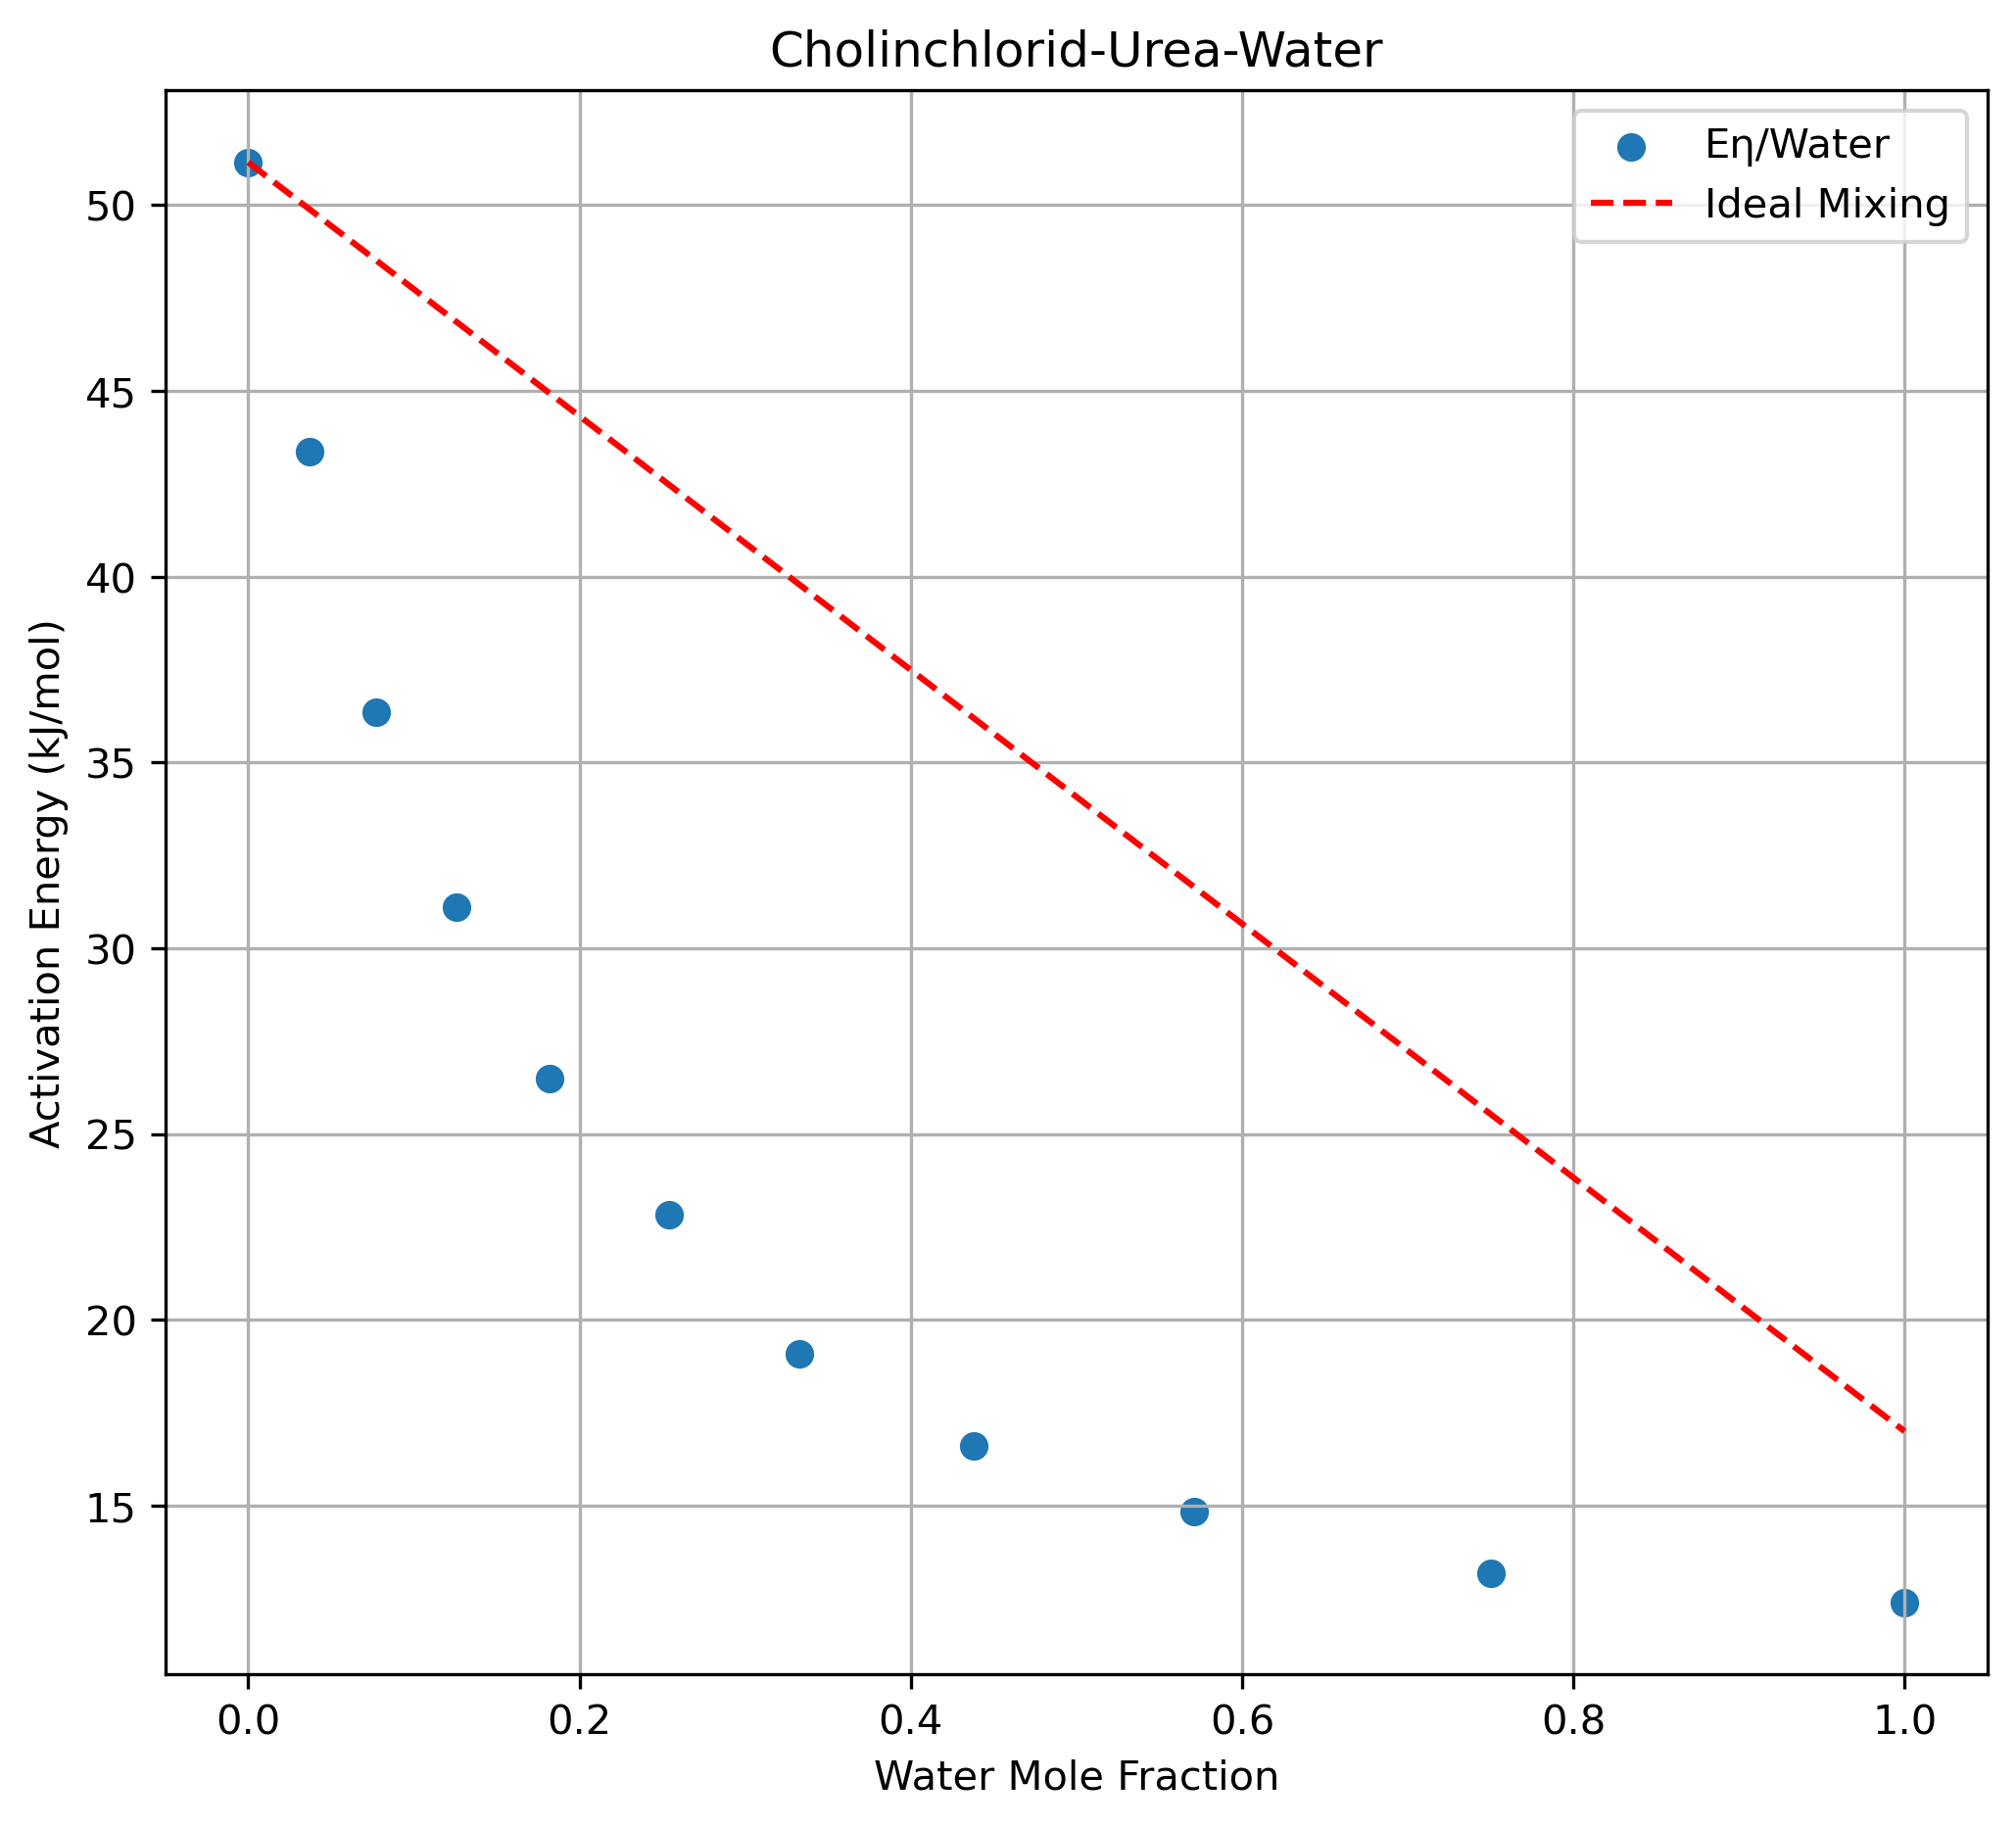

In [59]:
# Calculate ideal fluid activation energy
# Using linear combination rule: E_act = x_water * E_water + (1-x_water) * E_DES
E_water = 17.0  # Activation energy of pure water in kJ/mol
E_DES = max(E_values)  # Use highest activation energy (pure DES) as reference

# Generate smooth line for ideal behavior
x_water_ideal = np.linspace(0, 1, 100)
E_ideal = [x*E_water + (1-x)*E_DES for x in x_water_ideal]

# Add ideal line to previous plot
plt.figure(figsize=(8,7), dpi=300)
plt.scatter(water_fractions, E_values, label="Eη/Water")

plt.plot(x_water_ideal, E_ideal, 'r--', label='Ideal Mixing')
plt.xlabel('Water Mole Fraction')
plt.ylabel('Activation Energy (kJ/mol)')
plt.title('Cholinchlorid-Urea-Water')
plt.savefig('3.png', dpi=300)
plt.grid(True)
plt.legend()
plt.show()



Activation Energies (kJ/mol) for each water fraction:
x_water = 0.000: 44.96
x_water = 0.108: 40.37
x_water = 0.238: 37.59
x_water = 0.254: 41.60
x_water = 0.343: 34.74
x_water = 0.402: 33.53
x_water = 0.598: 28.87
x_water = 0.720: 24.94
x_water = 0.800: 22.37
x_water = 0.857: 18.89
x_water = 0.901: 17.21
x_water = 0.933: 16.01
x_water = 0.960: 15.55
x_water = 0.982: 14.91
x_water = 1.000: 13.96

Activation Energies vs Water Content:
Water fraction: 0.0000, Activation Energy: 44.96 kJ/mol
Water fraction: 0.1080, Activation Energy: 40.37 kJ/mol
Water fraction: 0.2380, Activation Energy: 37.59 kJ/mol
Water fraction: 0.2540, Activation Energy: 41.60 kJ/mol
Water fraction: 0.3430, Activation Energy: 34.74 kJ/mol
Water fraction: 0.4020, Activation Energy: 33.53 kJ/mol
Water fraction: 0.5980, Activation Energy: 28.87 kJ/mol
Water fraction: 0.7200, Activation Energy: 24.94 kJ/mol
Water fraction: 0.8000, Activation Energy: 22.37 kJ/mol
Water fraction: 0.8570, Activation Energy: 18.89 kJ/mol
W

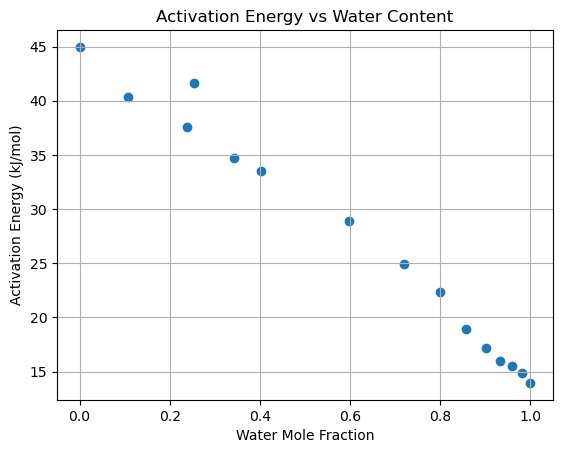

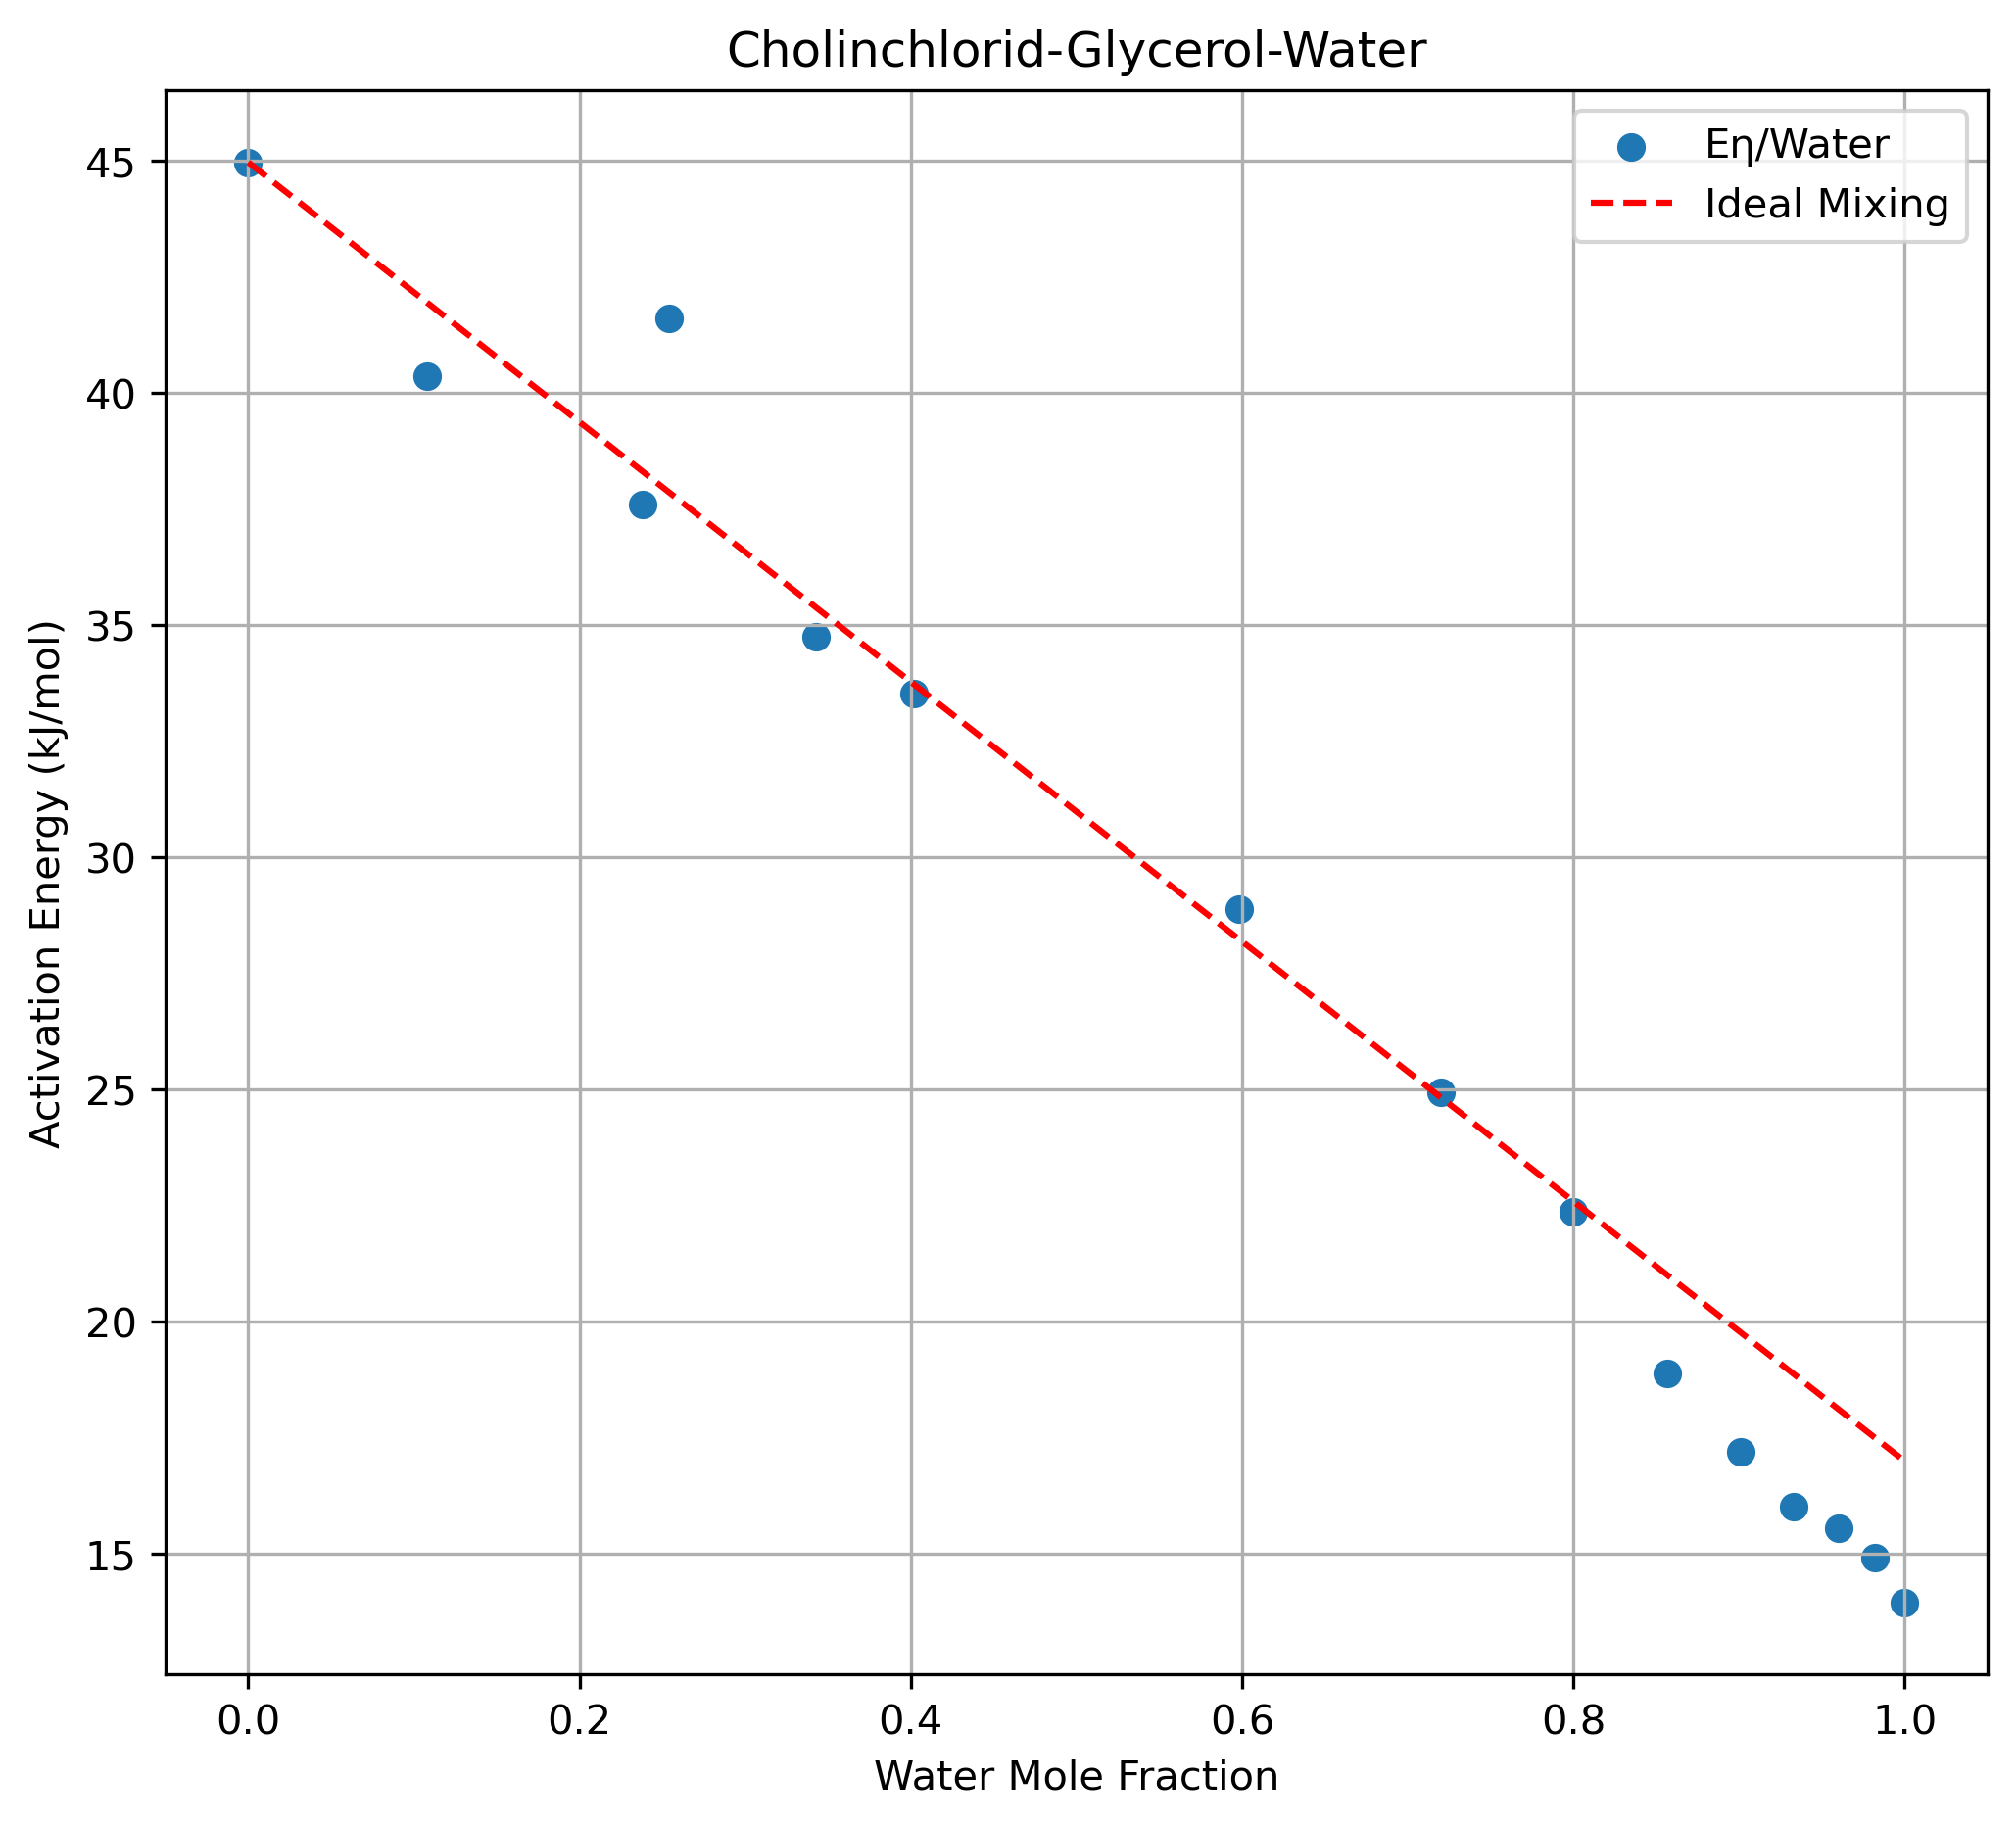

In [60]:
# Calculate activation energy (E) for each water fraction
activation_energies = {}
R = 8.314  # Gas constant in J/(mol·K)

# Read the ChCl-glycerol data
df2 = pd.read_csv('FAIRFluids/data/csvs/exp_ChCl_glycerol.csv')

for mole_frac, group in df2.groupby('mole fraction of water (mol/mol)'):
    # Only analyze groups with at least 3 temperature points
    if len(group) >= 3:
        temps = 1/(group['temperature (K)'])
        log_visc = np.log(group['Viscosity(cP)'])
        
        # Reshape for sklearn
        X = temps.values.reshape(-1, 1)
        y = log_visc.values.reshape(-1, 1)
        
        # Fit linear regression
        reg = LinearRegression().fit(X, y)
        
        # Calculate activation energy (slope * R)
        E = reg.coef_[0][0] * R
        activation_energies[f'x_water = {mole_frac:.3f}'] = E/1000  # Convert to kJ/mol

print("\nActivation Energies (kJ/mol) for each water fraction:")
for water_frac, E in activation_energies.items():
    print(f"{water_frac}: {E:.2f}")

# Plot activation energies vs water fraction
water_fractions = [float(key.split('=')[1]) for key in activation_energies.keys()]
E_values = list(activation_energies.values())
# Print activation energies in order of increasing water content
print("\nActivation Energies vs Water Content:")
sorted_items = sorted(zip(water_fractions, E_values))
for water_frac, E in sorted_items:
    print(f"Water fraction: {water_frac:.4f}, Activation Energy: {E:.2f} kJ/mol")

plt.figure()
plt.scatter(water_fractions, E_values)
plt.xlabel('Water Mole Fraction')
plt.ylabel('Activation Energy (kJ/mol)')
plt.title('Activation Energy vs Water Content')
plt.grid(True)
plt.show()

# Calculate ideal fluid activation energy
# Using linear combination rule: E_act = x_water * E_water + (1-x_water) * E_DES
E_water = 17.0  # Activation energy of pure water in kJ/mol
E_DES = max(E_values)  # Use highest activation energy (pure DES) as reference

# Generate smooth line for ideal behavior
x_water_ideal = np.linspace(0, 1, 100)
E_ideal = [x*E_water + (1-x)*E_DES for x in x_water_ideal]

# Add ideal line to previous plot
plt.figure(figsize=(8,7), dpi=300
           )
plt.scatter(water_fractions, E_values, label="Eη/Water")

plt.plot(x_water_ideal, E_ideal, 'r--', label='Ideal Mixing')
plt.xlabel('Water Mole Fraction')
plt.ylabel('Activation Energy (kJ/mol)')
plt.title('Cholinchlorid-Glycerol-Water')
plt.savefig('4.png', dpi=300)
plt.grid(True)
plt.legend()
plt.show()